In [1]:
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,
)
from tqdm.auto import tqdm


In [2]:
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

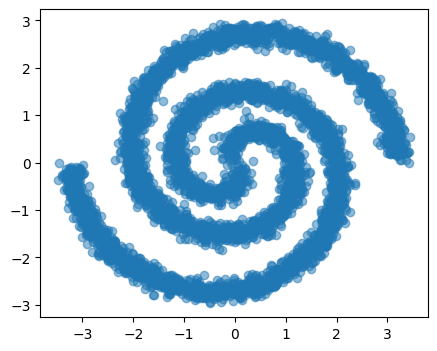

In [3]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(5000,2))
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.5)
plt.show()

In [16]:
I,It = get_trig_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(1024,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [17]:
b_optim = optax.adamw(1e-3)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 20000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)

eta_optim = optax.adamw(1e-3)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 20000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/20000 [00:00<?, ?it/s]

step=0 | train_loss=-0.004229701 | test_loss= -0.6072174
step=5000 | train_loss=-1.8863486 | test_loss= -1.8247273
step=10000 | train_loss=-2.325622 | test_loss= -2.0544977
step=15000 | train_loss=-1.3668582 | test_loss= -2.1316965
step=19999 | train_loss=-2.2463255 | test_loss= -2.2022734


  0%|          | 0/20000 [00:00<?, ?it/s]

step=0 | train_loss=0.14061826 | test_loss= -0.28326672
step=5000 | train_loss=-0.3580834 | test_loss= -0.3781281
step=10000 | train_loss=-0.392564 | test_loss= -0.38449594
step=15000 | train_loss=-0.38244653 | test_loss= -0.38581052
step=19999 | train_loss=-0.39660746 | test_loss= -0.38696623


In [30]:
eps = 0.0
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)

@eqx.filter_jit
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))


X0 = reference_samples.copy()


t0, t1 = 0.0, 1.0
diffusion = lambda t, x, args: jnp.sqrt(2*epsilon(t)) #* jnp.ones_like(x)

brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-6, shape=X0.shape, key=jax.random.PRNGKey(103))
terms = MultiTerm(ODETerm(dX_t), WeaklyDiagonalControlTerm(diffusion, brownian_motion))



solver = Euler()
saveat = SaveAt(dense=True)

sol = diffeqsolve(terms, solver, t0, t1, dt0=0.001, y0=X0, saveat=saveat)
X = sol.evaluate(1.0)
#print(X)  

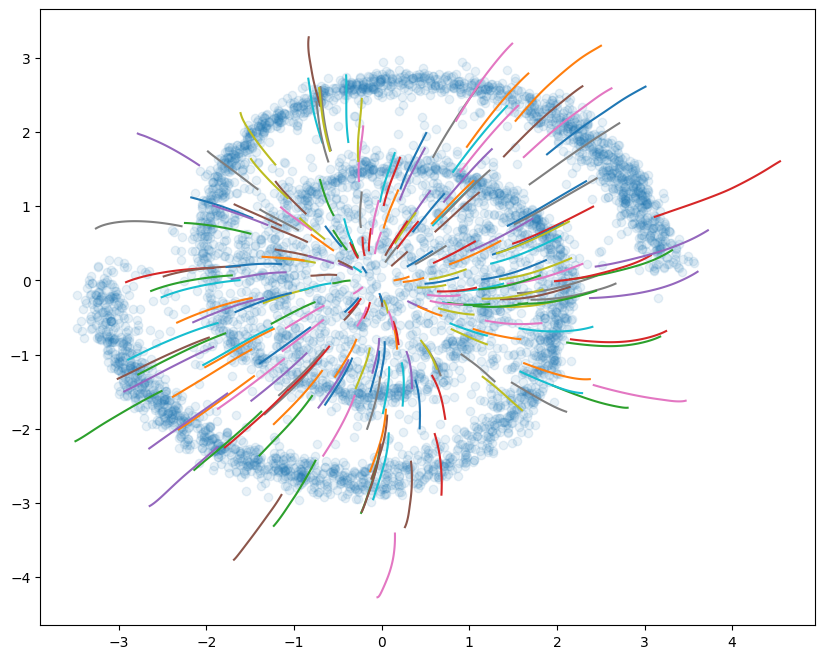

In [32]:
time_points = np.linspace(0,0.5,100)

path = jnp.array([sol.evaluate(t)[:200] for t in time_points])
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

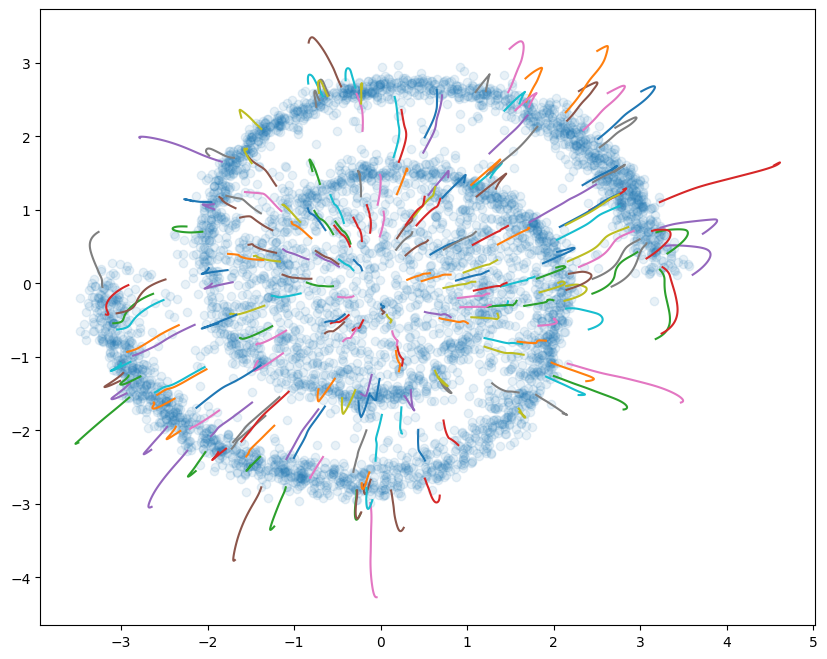

In [33]:
time_points = np.linspace(0.5,1,100)

path = jnp.array([sol.evaluate(t)[:200] for t in time_points])
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

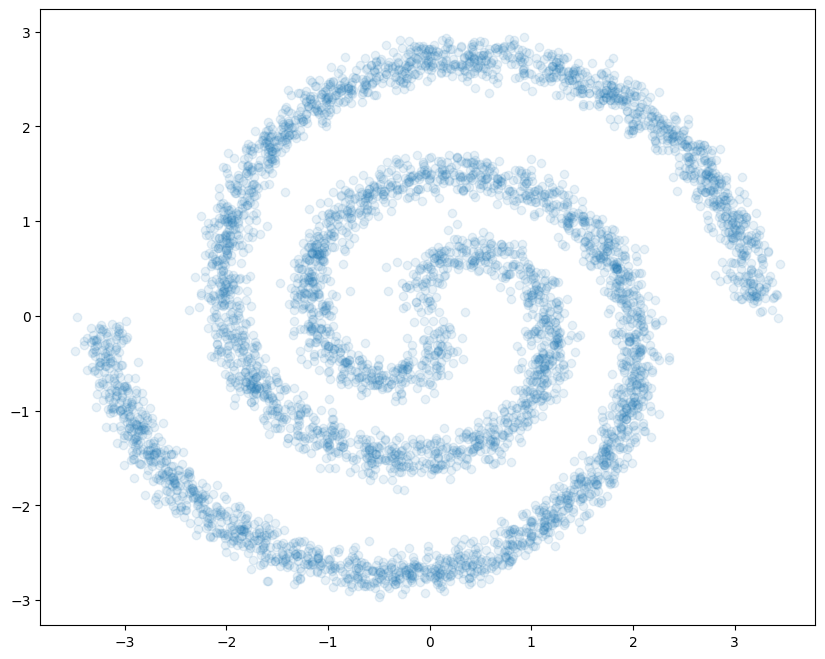

In [21]:
plt.figure(figsize=(10,8))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
